# BaF


This is aiming to reproduce and understand the results from [An ultracold molecular beam for testing fundamental physics](https://iopscience.iop.org/article/10.1088/2058-9565/ac107e)

## Loading packages

In [20]:
using
    Revise,
    QuantumStates,            # for calculating molecular structure
    OpticalBlochEquations,    # for solving optical Bloch equations
    UnitsToValue,              # for numerical values
    DifferentialEquations, # for differential equations (with
    Plots,                    # for plotting
    # PlotlyJS,              # for interactive plots
    Statistics,              # for statistics
    LinearAlgebra,       # for linear algebra
    StaticArrays,        # for static arrays
    DataFrames           # for data frames
pyplot();

## Defining the energy structure

### Ground state Hamiltonian for the $X^2\Sigma^+(N=1)$

Includes defining a magnetic field given by $$\vec B = B_0 (0, 1/\sqrt{2}, 1/\sqrt{2})$$

In [21]:
speedoflight = 29979.2458 #cm MHz
# Quantum Number Bounds
# Define the quantum number bounds for the system. Here, S, I, Λ, and N represent
# the spin, nuclear spin, projection of the electronic orbital angular momentum
# along the molecular axis, and the rotational quantum number, respectively.
QN_bounds = (
    label = "X",
    S = 1/2,           # Spin quantum number
    I = 1/2,           # Nuclear spin quantum number
    Λ = 0,             # Projection of the electronic orbital angular momentum
    N = 0:3            # Rotational quantum number range
)

# Generate all possible quantum states for a Hund's case (b) linear molecule
X_state_basis = order_basis_by_m(enumerate_states(HundsCaseB_LinearMolecule, QN_bounds))

# Define the Hamiltonian Operator
X_state_operator = :(
    BX * Rotation +                     # Rotational energy term, 0.2159509 cm^-1
    DX * RotationDistortion +           # Rotational distortion energy term
    γX * SpinRotation +                 # Spin-rotation interaction term, 2.7246e-3 cm^-1
    bFX * Hyperfine_IS +                # Hyperfine interaction (Fermi contact term)
    cX * (Hyperfine_Dipolar / 3)        # Hyperfine interaction (dipolar term)
)

# Define the Parameters for the Hamiltonian
# These parameters are specific to the YbF molecule and are given in Hertz (Hz).
X_state_parameters = QuantumStates.@params begin
    BX = 0.215947871 * c * 1e2         # Rotational constant in Hz
    DX = 0.                  # Rotational distortion constant in Hz (set to 0 for simplicity)
    γX = 0.00269905 * c * 1e2         # Spin-rotation interaction constant in Hz
    bFX = 0.00219651 * c * 1e2  # Fermi contact term in Hz
    cX = 0.000243647 * c * 1e2     # Dipolar hyperfine interaction constant in Hz
end

# Create the Hamiltonian
# Combine the basis states, operator, and parameters to define the Hamiltonian.
X_state_ham = Hamiltonian(basis=X_state_basis, operator=X_state_operator, parameters=X_state_parameters)

# Evaluate and Solve the Hamiltonian
# Compute the energy levels and eigenstates of the Hamiltonian.
evaluate!(X_state_ham)
QuantumStates.solve!(X_state_ham)
ground_states = X_state_ham.states[5:16] #subspace(X_state_ham.states,(N=1,))[1]
;

### Create Hamiltonian for the $A^2\Pi_{1/2}(000, J=1/2+)$ state

In [22]:
QN_bounds = (
    label = "A",
    S = 1/2,
    I = 1/2,
    Λ = (-1,1),
    J = 1/2:3/2 # ?
)
A_state_basis = order_basis_by_m(enumerate_states(HundsCaseA_LinearMolecule, QN_bounds))

A_state_operator = :(
    T_A * DiagonalOperator +
    Be_A * Rotation +
    Aso_A * SpinOrbit +
    q_A * ΛDoubling_q +
    p_A * ΛDoubling_p2q +
    a_A * Hyperfine_IL +
    d_A * Hyperfine_Dipolar_d
)

# Spectroscopic constants for YbF, A state
A_state_parameters = QuantumStates.@params begin
    T_A = 11946.317075 * c * 1e2   # Diagonal constant (electron zero point energy)
    Be_A = 0.21171 * c * 1e2  # Rotational constant, taken from X state
    Aso_A = 632.28175 * c * 1e2    # A spin-orbit constant
    p_A = -0.257550  * c * 1e2
    q_A = 0
    a_A = 0.000978 * c * 1e2
    d_A = -0.1194e-3 * c * 1e2
end

A_state_ham = Hamiltonian(basis=A_state_basis, operator=A_state_operator, parameters=A_state_parameters)
evaluate!(A_state_ham)
QuantumStates.solve!(A_state_ham)

# Add Zeeman terms
# Spectroscopic constants from "Optical Zeeman Spec... YbF" (Steimle and others)
const gL′ = 0.98 #0.996
const gl′ = -0.536 #-0.8016

M_x(M) = (state, state′) -> (M(state, state′, -1) - M(state, state′, +1)) / √2
M_y(M) = (state, state′) -> im * (M(state, state′, -1) + M(state, state′, +1)) / √2
M_z(M) = (state, state′) -> M(state, state′, 0)

A_state_ham = add_to_H(A_state_ham, :B_x, (1e-4 * gS * μB / h) * M_x(Zeeman_S) + (1e-4 * gL′ * μB / h) * M_x(Zeeman_L) + (1e-4 * gl′ * μB / h) * M_x(Zeeman_gl′))
A_state_ham = add_to_H(A_state_ham, :B_y, (1e-4 * gS * μB / h) * M_y(Zeeman_S) + (1e-4 * gL′ * μB / h) * M_y(Zeeman_L) + (1e-4 * gl′ * μB / h) * M_y(Zeeman_gl′))
A_state_ham = add_to_H(A_state_ham, :B_z, (1e-4 * gS * μB / h) * M_z(Zeeman_S) + (1e-4 * gL′ * μB / h) * M_z(Zeeman_L) + (1e-4 * gl′ * μB / h) * M_z(Zeeman_gl′))

A_state_ham.parameters.B_z = 0.0
A_state_ham.parameters.B_x = 0.0
A_state_ham.parameters.B_y = 0.0

evaluate!(A_state_ham)
QuantumStates.solve!(A_state_ham)

# Now we can convert it to HundsCaseB
excited_idx = subspace(A_state_ham.states,(J=1/2,))[1][5:8]
excited_states = A_state_ham.states[excited_idx]
QN_bounds = (
    S = 1/2,
    I = 1/2,
    Λ = (-1,1),
    N = 0:3
)
A_state_basis = order_basis_by_m(enumerate_states(HundsCaseB_LinearMolecule, QN_bounds))
excited_states = convert_basis(excited_states, A_state_basis)

states = [ground_states; excited_states]
;

In [23]:
# A few constants used for the simulation
λ = 860e-9 # Wavelength of light in meters
Γ = 2π * 1/(2π * 57.1e-9)
m = @with_unit 157 "u" # Mass of the molecule in atomic mass units
k = 2π / λ
;

In [24]:
function define_lasers_XY_perp(states, ϕ)
    # note: ϕs are laser phases
    
    E1 = energy(states[1])
    E2 = energy(states[4])
    E3 = energy(states[5])
    E4 = energy(states[8])
    
    # Three ways of getting excited state position
    E_excited = energy(states[16])/4+3*energy(states[14])/4 #Center of mass
    # E_excited = energy(states[16]) #Highest, F=0
    # E_excited = energy(states[13]) #Lowest, F=1

    detuning = +6Γ

    ω1 = 2π * (E_excited - E1) + detuning
    ω2 = 2π * (E_excited - E2) + detuning
    ω3 = 2π * (E_excited - E3) + detuning
    ω4 = 2π * (E_excited - E4) + detuning
    
    ϵ(ϵ_val) = t -> ϵ_val
    s_func(s) = (r,t) -> s

    # s = 3*200.
    # s1 = s_func(s/3)
    # s2 = s_func(s/3)
    # s3 = s_func(s/3)
    # s4 = s_func(0.0*s/3)
    
    s = 400.
    s1 = s_func(s/2)
    s2 = s_func(0.0*s/3)
    s3 = s_func(s/2)
    s4 = s_func(0.0*s/3)
    
    xpol = (-σ⁺ + σ⁻)/√2
    ypol = im * (σ⁺ + σ⁻)/√2
    pol1x = σ⁰
    pol1y = xpol
    pol2x = σ⁰
    pol2y = xpol
    pol3x = σ⁰
    pol3y = xpol
    pol4x = σ⁰
    pol4y = xpol

    # note that phases are defined to be the same for each direction x and y
    k̂ = +x̂; ϵ1 = ϵ(pol1x); laser1 = Field(k̂, ϵ1, ω1, s1)
    k̂ = -x̂; ϵ2 = ϵ(pol1x); laser2 = Field(k̂, ϵ2, ω1, s1)
    k̂ = +ŷ; ϵ3 = ϵ(exp(im*ϕ) * pol1y); laser3 = Field(k̂, ϵ3, ω1 + 2π*1e6, s1)
    k̂ = -ŷ; ϵ4 = ϵ(exp(im*ϕ) * pol1y); laser4 = Field(k̂, ϵ4, ω1 + 2π*1e6, s1)
    
    lasers_XY_perp_1 = [laser1, laser2, laser3, laser4]
    
    k̂ = +x̂; ϵ5 = ϵ(pol2x); laser5 = Field(k̂, ϵ5, ω2, s2)
    k̂ = -x̂; ϵ6 = ϵ(pol2x); laser6 = Field(k̂, ϵ6, ω2, s2)
    k̂ = +ŷ; ϵ7 = ϵ(exp(im*ϕ) * pol2y); laser7 = Field(k̂, ϵ7, ω2 + 2π*1e6, s2)
    k̂ = -ŷ; ϵ8 = ϵ(exp(im*ϕ) * pol2y); laser8 = Field(k̂, ϵ8, ω2 + 2π*1e6, s2)
    
    lasers_XY_perp_2 = [laser5, laser6, laser7, laser8]
    
    k̂ = +x̂; ϵ9  = ϵ(pol3x); laser9  = Field(k̂, ϵ9, ω3, s3)
    k̂ = -x̂; ϵ10 = ϵ(pol3x); laser10 = Field(k̂, ϵ10, ω3, s3)
    k̂ = +ŷ; ϵ11 = ϵ(exp(im*ϕ) * pol3y); laser11 = Field(k̂, ϵ11, ω3 + 2π*1e6, s3)
    k̂ = -ŷ; ϵ12 = ϵ(exp(im*ϕ) * pol3y); laser12 = Field(k̂, ϵ12, ω3 + 2π*1e6, s3)
    
    lasers_XY_perp_3 = [laser9, laser10, laser11, laser12]

    k̂ = +x̂; ϵ13  = ϵ(pol4x); laser13  = Field(k̂, ϵ13, ω4, s4)
    k̂ = -x̂; ϵ14 = ϵ(pol4x); laser14 = Field(k̂, ϵ14, ω4, s4)
    k̂ = +ŷ; ϵ15 = ϵ(exp(im*ϕ) * pol4y); laser15 = Field(k̂, ϵ15, ω4 + 2π*1e6, s4)
    k̂ = -ŷ; ϵ16 = ϵ(exp(im*ϕ) * pol4y); laser16 = Field(k̂, ϵ16, ω4 + 2π*1e6, s4)
    
    lasers_XY_perp_4 = [laser13, laser14, laser15, laser16]
    
    lasers = [lasers_XY_perp_1; lasers_XY_perp_2; lasers_XY_perp_3; lasers_XY_perp_4]

    return lasers
end
    
    
function define_lasers_XY_par4(states, ϕ, power, det)
    # note: ϕs are laser phases
    
    E1 = energy(states[2])
    E2 = energy(states[4])
    E3 = energy(states[6])
    E4 = energy(states[10])

    # E1=(E1+E2)/2
    # E3 = (E3+E4)/2

    # E1=(3*E1+E2)/4
    # E3 = (3*E3+5*E4)/8
    
    # Three ways of getting excited state position
    E_excited = energy(states[16])/4+3*energy(states[14])/4 #Center of mass
    # E_excited = energy(states[16]) #Highest, F=0
    # E_excited = energy(states[13]) #Lowest, F=1

    detuning = det

    ω1 = 2π * (E_excited - E1) + detuning
    ω2 = 2π * (E_excited - E2) + detuning
    ω3 = 2π * (E_excited - E3) + detuning
    ω4 = 2π * (E_excited - E4) + detuning
    
    ϵ(ϵ_val) = t -> ϵ_val
    s_func(s) = (r,t) -> s

    s = power

    # s1 = s_func(s/2)
    # s2 = s_func(0.)
    # s3 = s_func(s/2)
    # s4 = s_func(0.)
    
    s1 = s_func(s/4)
    s2 = s_func(s/4)
    s3 = s_func(s/4)
    s4 = s_func(s/4)

    # s1 = s_func(3*s/12)
    # s2 = s_func(s/12)
    # s3 = s_func(3*s/12)
    # s4 = s_func(5*s/12)
    
    # s = 3*200.
    # s1 = s_func(s/3)
    # s2 = s_func(s/3)
    # s3 = s_func(s/3)
    # s4 = s_func(0.0*s/3)
    
    pol1 = σ⁰
    pol2 = σ⁰
    pol3 = σ⁰
    pol4 = σ⁰

    # note that phases are defined to be the same for each direction x and y
    k̂ = +x̂; ϵ1 = ϵ(pol1); laser1 = Field(k̂, ϵ1, ω1, s1)
    # k̂ = -x̂; ϵ2 = ϵ(pol1); laser2 = Field(k̂, ϵ2, ω1, s1)
    # k̂ = +ŷ; ϵ3 = ϵ(exp(im*ϕ) * pol1); laser3 = Field(k̂, ϵ3, ω1 + 2π*1e6, s1)
    # k̂ = -ŷ; ϵ4 = ϵ(exp(im*ϕ) * pol1); laser4 = Field(k̂, ϵ4, ω1 + 2π*1e6, s1)
    
    # lasers_XY_parallel_1 = [laser1, laser2, laser3, laser4]
    
    k̂ = +x̂; ϵ5 = ϵ(pol2); laser5 = Field(k̂, ϵ5, ω2, s2)
    # k̂ = -x̂; ϵ6 = ϵ(pol2); laser6 = Field(k̂, ϵ6, ω2, s2)
    # k̂ = +ŷ; ϵ7 = ϵ(exp(im*ϕ) * pol2); laser7 = Field(k̂, ϵ7, ω2 + 2π*1e6, s2)
    # k̂ = -ŷ; ϵ8 = ϵ(exp(im*ϕ) * pol2); laser8 = Field(k̂, ϵ8, ω2 + 2π*1e6, s2)
    
    # lasers_XY_parallel_2 = [laser5, laser6, laser7, laser8]
    
    k̂ = +x̂; ϵ9  = ϵ(pol3); laser9  = Field(k̂, ϵ9, ω3, s3)
    # k̂ = -x̂; ϵ10 = ϵ(pol3); laser10 = Field(k̂, ϵ10, ω3, s3)
    # k̂ = +ŷ; ϵ11 = ϵ(exp(im*ϕ) * pol3); laser11 = Field(k̂, ϵ11, ω3 + 2π*1e6, s3)
    # k̂ = -ŷ; ϵ12 = ϵ(exp(im*ϕ) * pol3); laser12 = Field(k̂, ϵ12, ω3 + 2π*1e6, s3)
    
    # lasers_XY_parallel_3 = [laser9, laser10, laser11, laser12]

    k̂ = +x̂; ϵ13  = ϵ(pol4); laser13  = Field(k̂, ϵ13, ω4, s4)
    # k̂ = -x̂; ϵ14 = ϵ(pol4); laser14 = Field(k̂, ϵ14, ω4, s4)
    # k̂ = +ŷ; ϵ15 = ϵ(exp(im*ϕ) * pol4); laser15 = Field(k̂, ϵ15, ω4 + 2π*1e6, s4)
    # k̂ = -ŷ; ϵ16 = ϵ(exp(im*ϕ) * pol4); laser16 = Field(k̂, ϵ16, ω4 + 2π*1e6, s4)
    
    # lasers_XY_parallel_4 = [laser13, laser14, laser15, laser16]
    
    lasers = [laser1, laser5, laser9, laser13]

    return lasers
end

function define_lasers_XY_par2(states, ϕ, power, det)
    # note: ϕs are laser phases
    
    E1 = energy(states[2])
    E2 = energy(states[4])
    E3 = energy(states[6])
    E4 = energy(states[10])

    # E1=(E1+E2)/2
    # E3 = (E3+E4)/2

    E1=(3*E1+E2)/4
    E3 = (3*E3+5*E4)/8
    
    # Three ways of getting excited state position
    E_excited = energy(states[16])/4+3*energy(states[14])/4 #Center of mass
    # E_excited = energy(states[16]) #Highest, F=0
    # E_excited = energy(states[13]) #Lowest, F=1

    detuning = det

    ω1 = 2π * (E_excited - E1) + detuning
    ω2 = 2π * (E_excited - E2) + detuning
    ω3 = 2π * (E_excited - E3) + detuning
    ω4 = 2π * (E_excited - E4) + detuning
    
    ϵ(ϵ_val) = t -> ϵ_val
    s_func(s) = (r,t) -> s

    s = power

    s1 = s_func(s/2)
    s2 = s_func(0.)
    s3 = s_func(s/2)
    s4 = s_func(0.)
    
    # s1 = s_func(s/4)
    # s2 = s_func(s/4)
    # s3 = s_func(s/4)
    # s4 = s_func(s/4)

    # s1 = s_func(3*s/12)
    # s2 = s_func(s/12)
    # s3 = s_func(3*s/12)
    # s4 = s_func(5*s/12)
    
    # s = 3*200.
    # s1 = s_func(s/3)
    # s2 = s_func(s/3)
    # s3 = s_func(s/3)
    # s4 = s_func(0.0*s/3)
    
    pol1 = σ⁰
    pol2 = σ⁰
    pol3 = σ⁰
    pol4 = σ⁰

    # note that phases are defined to be the same for each direction x and y
    k̂ = +x̂; ϵ1 = ϵ(pol1); laser1 = Field(k̂, ϵ1, ω1, s1)
    # k̂ = -x̂; ϵ2 = ϵ(pol1); laser2 = Field(k̂, ϵ2, ω1, s1)
    # k̂ = +ŷ; ϵ3 = ϵ(exp(im*ϕ) * pol1); laser3 = Field(k̂, ϵ3, ω1 + 2π*1e6, s1)
    # k̂ = -ŷ; ϵ4 = ϵ(exp(im*ϕ) * pol1); laser4 = Field(k̂, ϵ4, ω1 + 2π*1e6, s1)
    
    # lasers_XY_parallel_1 = [laser1, laser2, laser3, laser4]
    
    k̂ = +x̂; ϵ5 = ϵ(pol2); laser5 = Field(k̂, ϵ5, ω2, s2)
    # k̂ = -x̂; ϵ6 = ϵ(pol2); laser6 = Field(k̂, ϵ6, ω2, s2)
    # k̂ = +ŷ; ϵ7 = ϵ(exp(im*ϕ) * pol2); laser7 = Field(k̂, ϵ7, ω2 + 2π*1e6, s2)
    # k̂ = -ŷ; ϵ8 = ϵ(exp(im*ϕ) * pol2); laser8 = Field(k̂, ϵ8, ω2 + 2π*1e6, s2)
    
    # lasers_XY_parallel_2 = [laser5, laser6, laser7, laser8]
    
    k̂ = +x̂; ϵ9  = ϵ(pol3); laser9  = Field(k̂, ϵ9, ω3, s3)
    # k̂ = -x̂; ϵ10 = ϵ(pol3); laser10 = Field(k̂, ϵ10, ω3, s3)
    # k̂ = +ŷ; ϵ11 = ϵ(exp(im*ϕ) * pol3); laser11 = Field(k̂, ϵ11, ω3 + 2π*1e6, s3)
    # k̂ = -ŷ; ϵ12 = ϵ(exp(im*ϕ) * pol3); laser12 = Field(k̂, ϵ12, ω3 + 2π*1e6, s3)
    
    # lasers_XY_parallel_3 = [laser9, laser10, laser11, laser12]

    k̂ = +x̂; ϵ13  = ϵ(pol4); laser13  = Field(k̂, ϵ13, ω4, s4)
    # k̂ = -x̂; ϵ14 = ϵ(pol4); laser14 = Field(k̂, ϵ14, ω4, s4)
    # k̂ = +ŷ; ϵ15 = ϵ(exp(im*ϕ) * pol4); laser15 = Field(k̂, ϵ15, ω4 + 2π*1e6, s4)
    # k̂ = -ŷ; ϵ16 = ϵ(exp(im*ϕ) * pol4); laser16 = Field(k̂, ϵ16, ω4 + 2π*1e6, s4)
    
    # lasers_XY_parallel_4 = [laser13, laser14, laser15, laser16]
    
    lasers = [laser1, laser5, laser9, laser13]

    return lasers
end

function define_lasers_XY_par1(states, ϕ, power, det)
    # note: ϕs are laser phases
    
    E1 = energy(states[2])
    E2 = energy(states[4])
    E3 = energy(states[6])
    E4 = energy(states[10])

    # E1=(E1+E2)/2
    # E3 = (E3+E4)/2

    # E1=(3*E1+E2)/4
    # E3 = (3*E3+5*E4)/8
    
    # Three ways of getting excited state position
    E_excited = energy(states[16])/4+3*energy(states[14])/4 #Center of mass
    # E_excited = energy(states[16]) #Highest, F=0
    # E_excited = energy(states[13]) #Lowest, F=1

    detuning = det

    ω1 = 2π * (E_excited - E1) + detuning
    ω2 = 2π * (E_excited - E2) + detuning
    ω3 = 2π * (E_excited - E3) + detuning
    ω4 = 2π * (E_excited - E4) + detuning
    
    ϵ(ϵ_val) = t -> ϵ_val
    s_func(s) = (r,t) -> s

    s = power

    s1 = s_func(s)
    s2 = s_func(0.)
    s3 = s_func(0.)
    s4 = s_func(0.)
    
    # s1 = s_func(s/4)
    # s2 = s_func(s/4)
    # s3 = s_func(s/4)
    # s4 = s_func(s/4)

    # s1 = s_func(3*s/12)
    # s2 = s_func(s/12)
    # s3 = s_func(3*s/12)
    # s4 = s_func(5*s/12)
    
    # s = 3*200.
    # s1 = s_func(s/3)
    # s2 = s_func(s/3)
    # s3 = s_func(s/3)
    # s4 = s_func(0.0*s/3)
    
    pol1 = σ⁰
    pol2 = σ⁰
    pol3 = σ⁰
    pol4 = σ⁰

    # note that phases are defined to be the same for each direction x and y
    k̂ = +x̂; ϵ1 = ϵ(pol1); laser1 = Field(k̂, ϵ1, ω1, s1)
    # k̂ = -x̂; ϵ2 = ϵ(pol1); laser2 = Field(k̂, ϵ2, ω1, s1)
    # k̂ = +ŷ; ϵ3 = ϵ(exp(im*ϕ) * pol1); laser3 = Field(k̂, ϵ3, ω1 + 2π*1e6, s1)
    # k̂ = -ŷ; ϵ4 = ϵ(exp(im*ϕ) * pol1); laser4 = Field(k̂, ϵ4, ω1 + 2π*1e6, s1)
    
    # lasers_XY_parallel_1 = [laser1, laser2, laser3, laser4]
    
    k̂ = +x̂; ϵ5 = ϵ(pol2); laser5 = Field(k̂, ϵ5, ω2, s2)
    # k̂ = -x̂; ϵ6 = ϵ(pol2); laser6 = Field(k̂, ϵ6, ω2, s2)
    # k̂ = +ŷ; ϵ7 = ϵ(exp(im*ϕ) * pol2); laser7 = Field(k̂, ϵ7, ω2 + 2π*1e6, s2)
    # k̂ = -ŷ; ϵ8 = ϵ(exp(im*ϕ) * pol2); laser8 = Field(k̂, ϵ8, ω2 + 2π*1e6, s2)
    
    # lasers_XY_parallel_2 = [laser5, laser6, laser7, laser8]
    
    k̂ = +x̂; ϵ9  = ϵ(pol3); laser9  = Field(k̂, ϵ9, ω3, s3)
    # k̂ = -x̂; ϵ10 = ϵ(pol3); laser10 = Field(k̂, ϵ10, ω3, s3)
    # k̂ = +ŷ; ϵ11 = ϵ(exp(im*ϕ) * pol3); laser11 = Field(k̂, ϵ11, ω3 + 2π*1e6, s3)
    # k̂ = -ŷ; ϵ12 = ϵ(exp(im*ϕ) * pol3); laser12 = Field(k̂, ϵ12, ω3 + 2π*1e6, s3)
    
    # lasers_XY_parallel_3 = [laser9, laser10, laser11, laser12]

    k̂ = +x̂; ϵ13  = ϵ(pol4); laser13  = Field(k̂, ϵ13, ω4, s4)
    # k̂ = -x̂; ϵ14 = ϵ(pol4); laser14 = Field(k̂, ϵ14, ω4, s4)
    # k̂ = +ŷ; ϵ15 = ϵ(exp(im*ϕ) * pol4); laser15 = Field(k̂, ϵ15, ω4 + 2π*1e6, s4)
    # k̂ = -ŷ; ϵ16 = ϵ(exp(im*ϕ) * pol4); laser16 = Field(k̂, ϵ16, ω4 + 2π*1e6, s4)
    
    # lasers_XY_parallel_4 = [laser13, laser14, laser15, laser16]
    
    lasers = [laser1, laser5, laser9, laser13]

    return lasers
end

lasers_par = define_lasers_XY_par4(states, 0.5π,100,0.)
;
lasers_perp = define_lasers_XY_perp(states, 0.5π)
;

In [25]:
lasers_par = define_lasers_XY_par1(states, 0.5π,100,0.)

4-element Vector{Field{Float64, var"#87#90"{SVector{3, ComplexF64}}}}:
 Field{Float64, var"#87#90"{SVector{3, ComplexF64}}, var"#88#92"{Int64}}([1.0, 0.0, 0.0], var"#87#90"{SVector{3, ComplexF64}}(ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]), ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2.1907033667381438e15, var"#88#92"{Int64}(100), 0.0, 0.0, 0.0, 0.0, ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im])
 Field{Float64, var"#87#90"{SVector{3, ComplexF64}}, var"#88#92"{Float64}}([1.0, 0.0, 0.0], var"#87#90"{SVector{3, ComplexF64}}(ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]), ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2.1907031912036225e15, var"#88#92"{Float64}(0.0), 0.0, 0.0, 0.0, 0.0, ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im])
 Field{Float64, var"#87#90"{SVector{3, ComplexF64}}, var"#88#92"{Float64}}([1.0, 0.0, 0.0], var"#87#90"{SVector{3, ComplexF64}}(ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]), ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]

In [26]:
lasers_par = define_lasers_XY_par4(states, 0.5π,100,0.)

4-element Vector{Field{Float64, var"#75#78"{SVector{3, ComplexF64}}, var"#76#80"{Float64}}}:
 Field{Float64, var"#75#78"{SVector{3, ComplexF64}}, var"#76#80"{Float64}}([1.0, 0.0, 0.0], var"#75#78"{SVector{3, ComplexF64}}(ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]), ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2.1907033667381438e15, var"#76#80"{Float64}(25.0), 0.0, 0.0, 0.0, 0.0, ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im])
 Field{Float64, var"#75#78"{SVector{3, ComplexF64}}, var"#76#80"{Float64}}([1.0, 0.0, 0.0], var"#75#78"{SVector{3, ComplexF64}}(ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]), ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2.1907031912036225e15, var"#76#80"{Float64}(25.0), 0.0, 0.0, 0.0, 0.0, ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im])
 Field{Float64, var"#75#78"{SVector{3, ComplexF64}}, var"#76#80"{Float64}}([1.0, 0.0, 0.0], var"#75#78"{SVector{3, ComplexF64}}(ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]), ComplexF64[0.0 + 0.0i

In [27]:
evaluate!(X_state_ham)
QuantumStates.solve!(X_state_ham)
ground_states = X_state_ham.states[5:16]

states = [ground_states; excited_states]

# calculate transitions dipole moments
d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)
basis_tdms = get_tdms_two_bases(ground_states[1].basis, excited_states[1].basis, TDM)
tdms_between_states!(d_ge, basis_tdms, ground_states, excited_states)
d[1:12, 13:16, :] .= d_ge
;

In [28]:
# create matrices containing the Zeeman terms
using LoopVectorization, StructArrays

Zeeman_x(state, state′) = (Zeeman(state, state′,-1) - Zeeman(state, state′,1))/sqrt(2)
Zeeman_y(state, state′) = im*(Zeeman(state, state′,-1) + Zeeman(state, state′,1))/sqrt(2)
Zeeman_z(state, state′) = Zeeman(state, state′, 0)

Zeeman_x_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_x, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h)) # magnetic field in units of G
Zeeman_y_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_y, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))
Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, ground_states, excited_states) .* (1e-4 * gS * μB * (2π/Γ) / h))

# let's add effective Zeeman terms for the A state
Zeeman_A_x = (1e-4 * gS * μB / h) * M_x(Zeeman_S) + (1e-4 * gL′ * μB / h) * M_x(Zeeman_L) + (1e-4 * gl′ * μB / h) * M_x(Zeeman_gl′)
Zeeman_A_y = (1e-4 * gS * μB / h) * M_y(Zeeman_S) + (1e-4 * gL′ * μB / h) * M_y(Zeeman_L) + (1e-4 * gl′ * μB / h) * M_y(Zeeman_gl′)
Zeeman_A_z = (1e-4 * gS * μB / h) * M_z(Zeeman_S) + (1e-4 * gL′ * μB / h) * M_z(Zeeman_L) + (1e-4 * gl′ * μB / h) * M_z(Zeeman_gl′)

Zeeman_x_mat[13:16,13:16] .= (2π/Γ) .* operator_to_matrix(Zeeman_A_x, A_state_ham.states[excited_idx])
Zeeman_y_mat[13:16,13:16] .= (2π/Γ) .* operator_to_matrix(Zeeman_A_y, A_state_ham.states[excited_idx])
Zeeman_z_mat[13:16,13:16] .= (2π/Γ) .* operator_to_matrix(Zeeman_A_z, A_state_ham.states[excited_idx])

function update_H_and_∇H(H, p, r, t)

    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy

    Bx = p.sim_params.Bx
    By = p.sim_params.By
    Bz = p.sim_params.Bz
    
    @turbo for i in eachindex(H)
        H.re[i] = Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i] + Bz * Zeeman_Hz.re[i]
        H.im[i] = Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i] + Bz * Zeeman_Hz.im[i]
    end

    ∇H = SVector{3,ComplexF64}(0,0,0)
    
    return ∇H
end
;

In [29]:
B = 5

sim_params = (Bx=0*B/√2, By=B/√2, Bz=B/√2)
extra_data = (
    Zeeman_Hx=Zeeman_x_mat, 
    Zeeman_Hy=Zeeman_y_mat, 
    Zeeman_Hz=Zeeman_z_mat,
    states_static=states
)
;

In [30]:
# Set initial conditions
particle = Particle()
ρ0 = zeros(ComplexF64, length(states), length(states))
for i in 1:12
    ρ0[i,i] = 1.0/12
end
#ρ0[13,13] = 1.0

freq_res = 1e-2
p_par = obe(ρ0, particle, states, lasers_par, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res, extra_data=extra_data, sim_params=sim_params, update_H_and_∇H=update_H_and_∇H)
p_perp = obe(ρ0, particle, states, lasers_perp, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res, extra_data=extra_data, sim_params=sim_params, update_H_and_∇H=update_H_and_∇H)
;

In [31]:
using Plots

In [32]:
p=p_par;

In [33]:
p.period=100

100

In [34]:
p.r0 = (0.0, 0., 0.) ./ (1 / k)
p.v = (0.0, 1.0, 0.) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)

t_end = 10*p.period
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
times = range(0, t_end, 10000)

cb = PeriodicCallback(reset_force!, p.period)
@time sol = DifferentialEquations.solve(prob; alg=DP5(), callback=cb, reltol=1e-4, saveat=times)
# @time sol = DifferentialEquations.solve(prob; alg= QNDF(autodiff=false), callback=cb, reltol=1e-4, saveat=times,maxiters=1e6)

# Print the force
print("Force (10³ m/s): ", sol.prob.p.force_last_period * (1e-3 * ħ * k * Γ / m))

  3.288987 seconds (9.04 M allocations: 616.922 MiB, 5.26% gc time, 91.44% compilation time)
Force (10³ m/s): [4.695672617472368, 0.0, 0.0]

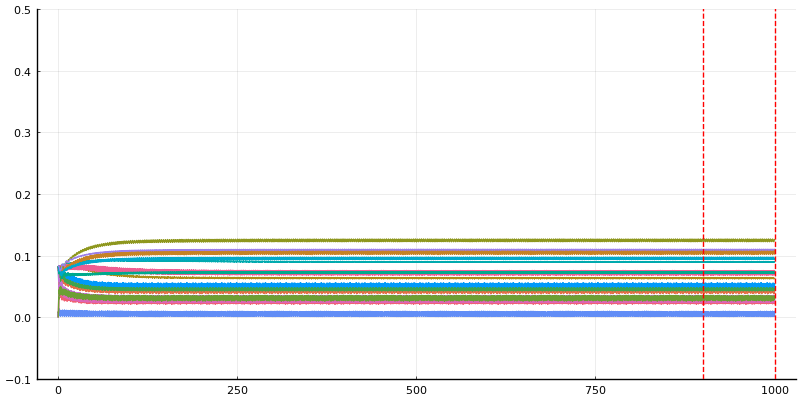

In [35]:
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(prob.p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 0.5))
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!(legend=nothing)
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

In [36]:
populations_timeseries = [ [ u[i + (i-1)*n_states] for i in 1:n_states ] for u in sol.u ];
pop_matrix = real(hcat(populations_timeseries...));
excited_tot = vec(sum(pop_matrix[13:16, :], dims=1));

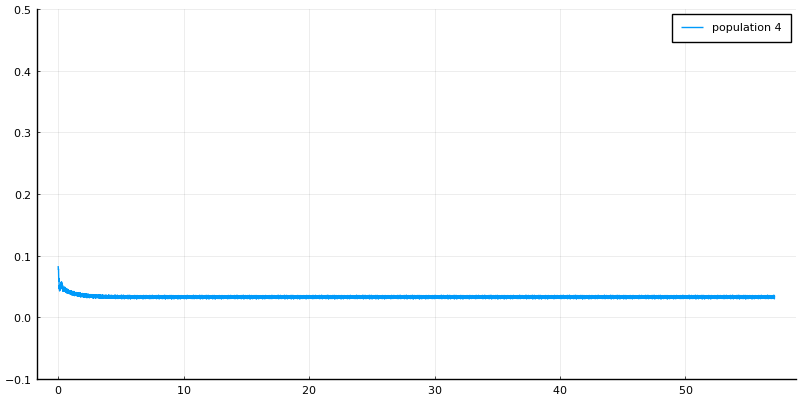

In [37]:
plt= plot(size=(800, 400), ylim=(-0.1, 0.5),label="Pop")
for i in 4
    plot!(sol.t*1/Γ*1e6, pop_matrix[i,:],label="population $i")
end
plt

In [38]:
states[6]

State{HundsCaseB_LinearMolecule}(1.2970568429566406e10, HundsCaseB_LinearMolecule[HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 3, 7/2, 4, -4, (K = 0, N = 0:∞, J = 2.5:1.0:3.5, F = 3.0:1.0:4.0, M = -4.0:1.0:4.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 2, 5/2, 3, -3, (K = 0, N = 0:∞, J = 1.5:1.0:2.5, F = 2.0:1.0:3.0, M = -3.0:1.0:3.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 3, 5/2, 3, -3, (K = 0, N = 0:∞, J = 2.5:1.0:3.5, F = 2.0:1.0:3.0, M = -3.0:1.0:3.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 3, 7/2, 3, -3, (K = 0, N = 0:∞, J = 2.5:1.0:3.5, F = 3.0:1.0:4.0, M = -3.0:1.0:3.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 3, 7/2, 4, -3, (K = 0, N = 0:∞, J = 2.5:1.0:3.5, F = 3.0:1.0:4.0, M = -4.0:1.0:4.0)), HundsCaseB_LinearMolecule(0.0, "X", 0, 0, 0, 1/2, 1/2, 0, 0, 0, 1, 3/2, 2, -2, (K = 0, N = 0:∞, J = 0.5:1.0:1.5, F = 1.0:1.0:2.0, M = -2.0:1.0:2.0)), HundsCaseB_LinearM

Averaged Scattering Rate over last cycle: 1.5872270665556494/μs

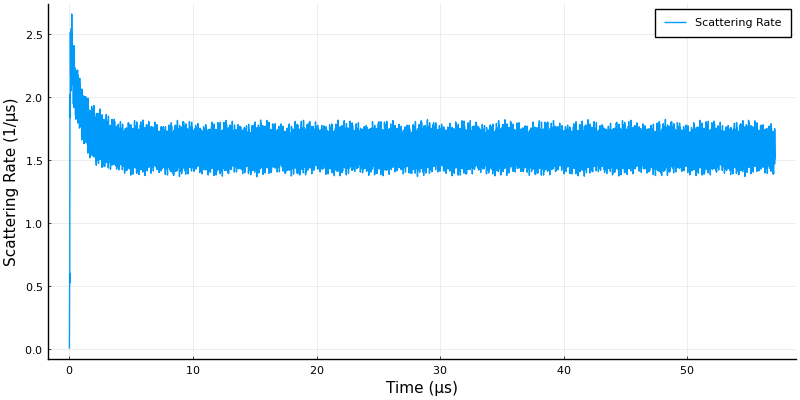

In [39]:
plt = plot(size=(800, 400),label="Scattering Rate")
plot!(sol.t*1/Γ*1e6, excited_tot*Γ/1e6,ylabel="Scattering Rate (1/μs)",label="Scattering Rate",xlabel="Time (μs)")
avg_scattering = mean(excited_tot[searchsortedfirst(sol.t, t_end-p.period):end]*Γ/1e6)
print("Averaged Scattering Rate over last cycle: ", avg_scattering, "/μs")
plt

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


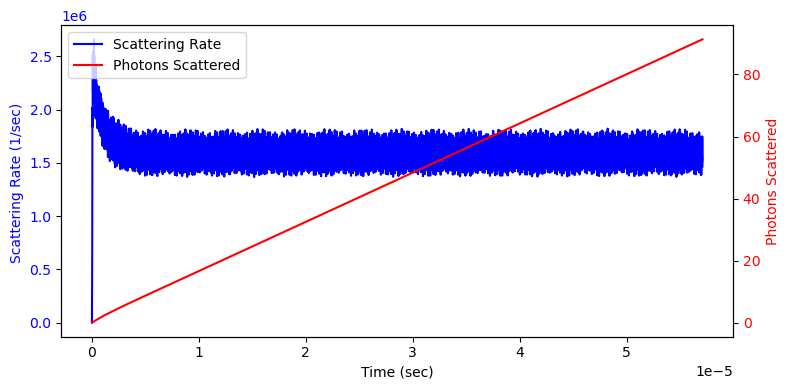

In [40]:
using PyPlot

# Create a figure and primary axis (left y-axis)
fig, ax1 = subplots(figsize=(8, 4))  # size in inches; adjust as needed

# Plot the scattering rate on the primary axis.
# We scale time by 1/Γ and the scattering rate by Γ, per your code.
ax1.plot(sol.t .* (1/Γ), excited_tot .* Γ, label="Scattering Rate", color="blue")
ax1.set_xlabel("Time (sec)")
ax1.set_ylabel("Scattering Rate (1/sec) ", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

# Compute the running integral (cumulative photons scattered) using the trapezoidal rule.
n = length(sol.t)
nphotons = zeros(n)
for i in 2:n
    dt = sol.t[i] - sol.t[i-1]
    # Average the two adjacent scattering rate values.
    nphotons[i] = nphotons[i-1] + dt * excited_tot[i-1]
end

# Create a second y-axis that shares the same x-axis.
ax2 = ax1.twinx()

# Plot the integrated scattering (photons scattered) on the secondary axis.
ax2.plot(sol.t .* (1/Γ), nphotons, label="Photons Scattered", color="red")
ax2.set_ylabel("Photons Scattered", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(vcat(lines1, lines2), vcat(labels1, labels2), loc="upper left")

fig.tight_layout()
show()


In [41]:
# populations_timeseries = [ [ u[i + (i-1)*n_states] for i in 1:n_states ] for u in sol.u ];
# pop_matrix = hcat(populations_timeseries...);

# using Plots

# plt = plot(size=(800, 400),ylim=(0.0,0.2))
# for i in 1:12
#     plot!(sol.t, real(pop_matrix[i,:]), label="Population $i")
# end
# plt

In [42]:
p=p_perp;

In [43]:
p.r0 = (0.0, 0., 0.) ./ (1 / k)
p.v = (0.0, 1.0, 0.) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)

t_end = 10p.period
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
times = range(0, t_end, 10000)

cb = PeriodicCallback(reset_force!, p.period)
@time sol = DifferentialEquations.solve(prob; alg=DP5(), callback=cb, reltol=1e-4, saveat=times)

# Print the force
print("Force (10³ m/s): ", sol.prob.p.force_last_period * (1e-3 * ħ * k * Γ / m))

  2.529310 seconds (5.00 M allocations: 337.562 MiB, 2.17% gc time, 62.14% compilation time)
Force (10³ m/s): [0.0, -1.8044080519724415, 0.0]

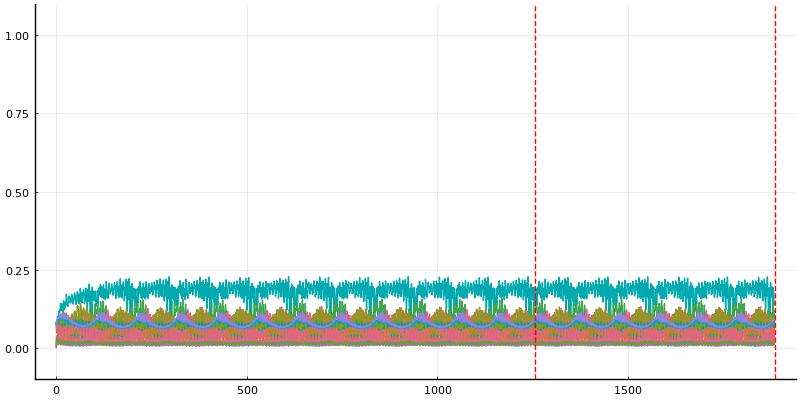

In [44]:
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(prob.p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1))
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!(legend=nothing)
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

# Replicating results with a simple run

In [50]:
using
    StaticArrays,
    RectiGrids,
    StatsBase

In [56]:
define_lasers_XY_par2(states, scan_values_grid[1].ϕ, scan_values_grid[1].s,scan_values_grid[1].det)

4-element Vector{Field{Float64, var"#81#84"{SVector{3, ComplexF64}}, var"#82#86"{Float64}}}:
 Field{Float64, var"#81#84"{SVector{3, ComplexF64}}, var"#82#86"{Float64}}([1.0, 0.0, 0.0], var"#81#84"{SVector{3, ComplexF64}}(ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]), ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2.1907033228544635e15, var"#82#86"{Float64}(5.0), 0.0, 0.0, 0.0, 0.0, ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im])
 Field{Float64, var"#81#84"{SVector{3, ComplexF64}}, var"#82#86"{Float64}}([1.0, 0.0, 0.0], var"#81#84"{SVector{3, ComplexF64}}(ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]), ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], 2.1907031912035725e15, var"#82#86"{Float64}(0.0), 0.0, 0.0, 0.0, 0.0, ComplexF64[0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im])
 Field{Float64, var"#81#84"{SVector{3, ComplexF64}}, var"#82#86"{Float64}}([1.0, 0.0, 0.0], var"#81#84"{SVector{3, ComplexF64}}(ComplexF64[0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im]), ComplexF64[0.0 + 0.0im,

In [57]:
function prob_func_par!(prob, scan_values_grid, i)

    p = prob.p
    
    particle = Particle()
    particle.v .= (0, scan_values_grid[i].v, 0)
    # particle.v .= (0, scan_values_grid[i].v, 0)

    states = p.extra_data.states_static
    lasers = define_lasers_XY_par2(states, scan_values_grid[i].ϕ, scan_values_grid[i].s,scan_values_grid[i].det)

    d = p.d
    extra_data = p.extra_data
    sim_params = p.sim_params

    # create new problem
    freq_res = 1e-2
    callback = PeriodicCallback(reset_force!, p.period)
    p = obe(ρ0, particle, states, lasers, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res, extra_data=extra_data, sim_params=sim_params, update_H_and_∇H=update_H_and_∇H)
    t_end = 10*p.period
    tspan = (0., t_end)
    prob′ = ODEProblem(ρ!, p.ρ0_vec, tspan, p; callback=callback, reltol=1e-5, save_on=false)
    
    return prob′
end

function prob_func_perp!(prob, scan_values_grid, i)

    p = prob.p
    
    particle = Particle()
    dir = scan_values_grid[i].dir
    particle.v .= (scan_values_grid[i].v * dir[1], scan_values_grid[i].v * dir[2], 0)
    # particle.v .= (0, scan_values_grid[i].v, 0)

    states = p.extra_data.states_static
    lasers = define_lasers_XY_perp(states, scan_values_grid[i].ϕ)

    d = p.d
    extra_data = p.extra_data
    sim_params = p.sim_params

    # create new problem
    freq_res = 1e-2
    callback = PeriodicCallback(reset_force!, p.period)
    p = obe(ρ0, particle, states, lasers, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res, extra_data=extra_data, sim_params=sim_params, update_H_and_∇H=update_H_and_∇H)
    prob′ = ODEProblem(ρ!, p.ρ0_vec, tspan, p; callback=callback, reltol=1e-5, save_on=false)
    
    return prob′
end

function output_func(p, sol)
    f = p.force_last_period
    return (f[1], f[2], f[3])
end
;

In [58]:
scan_values = (
        v = [0.0],
        ϕ = [0.0],
        s = 10,
        det = range(-50,stop=200,length=51)
    );
# scan_values = (
#         v = [0.0],
#         ϕ = [0.0],
#         s = 10.0 .^ range(0, stop=4, length=51),
#         det = [0.0]
#     );
ρ0 = zeros(ComplexF64, length(states), length(states))
for i in 1:12
    ρ0[i,i] = 1.0/12
end
extra_data = (
    Zeeman_Hx=Zeeman_x_mat, 
    Zeeman_Hy=Zeeman_y_mat, 
    Zeeman_Hz=Zeeman_z_mat,
    states_static=states
);
particle = Particle();

In [ ]:
par_pop_vs_B = Array{Float64}[]  # stores average population sums for each scan direction group
par_pop_std_vs_B = Array{Float64}[]  # stores average population sums for each scan direction group

scan_values_grid = RectiGrids.grid(scan_values)
freq_res = 1e-2
particle.v .= (0, 0., 0)
lasers = define_lasers_XY_par2(states, scan_values_grid[1].ϕ, scan_values_grid[1].s,scan_values_grid[1].det)

B_vals = (0:1:20)
for B in B_vals
    sim_params = (Bx=0.0*B/√2, By=B/√2, Bz=B/√2)
    p = obe(ρ0, particle, states, lasers, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res, 
        extra_data=extra_data, sim_params=sim_params, update_H_and_∇H=update_H_and_∇H)
    t_end = 10*p.period
    tspan = (0., t_end)
    prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-5, save_on=false)
    
    
    @time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func_par!, output_func)

    avg_pop_sums = Float64[]
    pop_std = Float64[]
    for (i, det) in enumerate(scan_values.det)
        idxs = [j for (j, x) in enumerate(scan_values_grid) if x.det == det]
        pop_sums = [sum(populations[j, end-3:end]) for j in idxs]  # sum of last 4 populations
        push!(avg_pop_sums, mean(pop_sums))
        push!(pop_std, std(pop_sums))
    end

    push!(par_pop_vs_B, avg_pop_sums)
    push!(par_pop_std_vs_B, pop_std)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


  5.596243 seconds (6.51 M allocations: 430.170 MiB, 1.06% gc time, 1354.40% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


  3.043884 seconds (129.29 k allocations: 18.280 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


  5.143346 seconds (130.60 k allocations: 18.466 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


  6.357926 seconds (130.66 k allocations: 18.469 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


  6.973969 seconds (130.25 k allocations: 18.438 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


  7.530152 seconds (130.71 k allocations: 18.474 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


  7.721423 seconds (130.28 k allocations: 18.942 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


  8.404277 seconds (131.26 k allocations: 18.518 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


  8.955335 seconds (129.96 k allocations: 18.413 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


  8.916492 seconds (130.58 k allocations: 18.463 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


  9.510081 seconds (130.15 k allocations: 18.429 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


  9.737963 seconds (130.92 k allocations: 18.490 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


 10.148731 seconds (130.89 k allocations: 18.486 MiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


  9.978075 seconds (130.81 k allocations: 18.480 MiB)


Progress:  90%|█████████████████████████████████████    |  ETA: 0:00:01

In [18]:
using Plots

n_scan_dirs = length(par_pop_vs_B[1])
pop_matrix = hcat(par_pop_vs_B...)'  # shape: (length(B_vals), n_scan_dirs)

heatmap(scan_values.det, B_vals, (abs.(pop_matrix)),
    xlabel = "Saturation Parameter",
    ylabel = "B field (G)",
    title = "Excited State Population, 2 sidebands",
    colorbar = true,
)

LoadError: BoundsError: attempt to access 0-element Vector{Array{Float64}} at index [1]

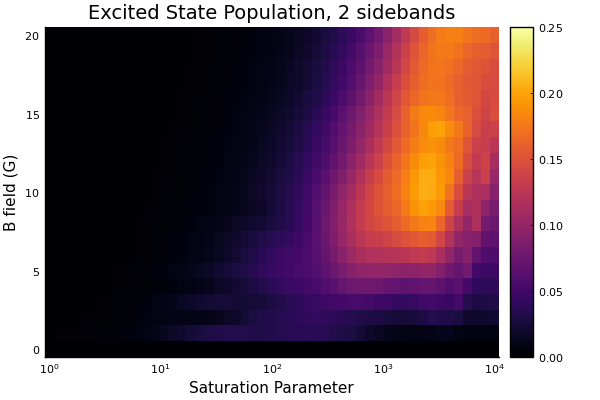

In [51]:
using Plots

n_scan_dirs = length(par_pop_vs_B[1])
pop_matrix = hcat(par_pop_vs_B...)'  # shape: (length(B_vals), n_scan_dirs)

heatmap(scan_values.s, B_vals, (abs.(pop_matrix)),
    xlabel = "Saturation Parameter",
    ylabel = "B field (G)",
    xscale = :log10,
    title = "Excited State Population, 2 sidebands",
    colorbar = true,
    clim = (0.0,(0.2501)),
)

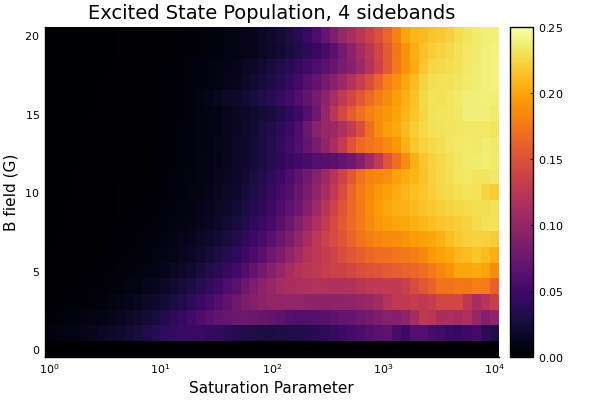

In [39]:
using Plots

n_scan_dirs = length(par_pop_vs_B[1])
pop_matrix = hcat(par_pop_vs_B...)'  # shape: (length(B_vals), n_scan_dirs)

heatmap(scan_values.s, B_vals, (abs.(pop_matrix)),
    xlabel = "Saturation Parameter",
    ylabel = "B field (G)",
    xscale = :log10,
    title = "Excited State Population, 4 sidebands",
    colorbar = true,
    clim = (0.0,(0.2501)),
)

In [ ]:
par_force_vs_B = Array{Float64}[]
par_force_std_vs_B = Array{Float64}[]
B_vals = [0,1,5,10,25]
for B in B_vals
    sim_params = (Bx=0, By=B/√2, Bz=B/√2)
    freq_res = 1e-2

    particle.v .= (0, 1., 0)
    p = obe(ρ0, particle, states, lasers_par, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res, 
        extra_data=extra_data, sim_params=sim_params, update_H_and_∇H=update_H_and_∇H)
    
    t_end = 10p.period
    tspan = (0., t_end)
    
    prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-5, save_on=false)
    
    scan_values_grid = RectiGrids.grid(scan_values)
    ;
    @time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func_par!, output_func)
    ;
    averaged_forces = Float64[]
    force_std = Float64[]
    for (i,v) ∈ enumerate(scan_values.v)
        idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
        push!(averaged_forces, mean([forces[idx] ⋅ scan_values_grid[idx].dir for idx in idxs]))
        push!(force_std, std([forces[idx] ⋅ scan_values_grid[idx].dir for idx in idxs]))
    end
    push!(par_force_vs_B,averaged_forces)
    push!(par_force_std_vs_B, force_std)
end

Progress:  32%|██████████████                           |  ETA: 0:00:15

In [1]:
?plot

search: prevfloat partialsort partialsort! partialsortperm partialsortperm!

Couldn't find plot
Perhaps you meant splat, split, prod, acot, cot, float, log, let, rsplit or peek


No documentation found.

Binding `plot` does not exist.


In [2]:
(string.(B_vals))

LoadError: UndefVarError: `B_vals` not defined

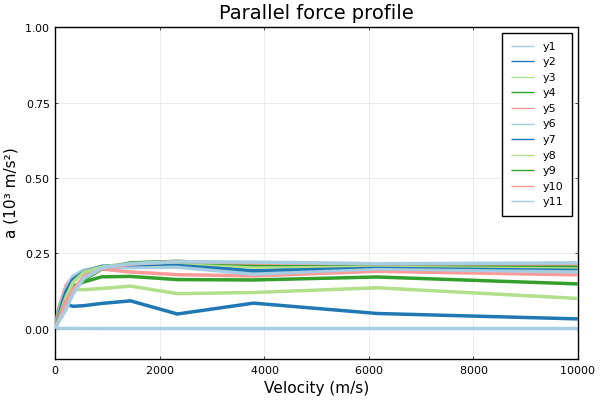

In [18]:
plot(scan_values.s,par_pop_vs_B,
        xlabel="Velocity (m/s)",
        ylabel="a (10³ m/s²)",
        title="Parallel force profile",
        framestyle=:box,
        linewidth=2.5,
        fillalpha = 0.2,
        # legend=nothing,
        xlim=(0,10000),
        ylim=(-0.1,1),
        palette=:Paired_5
    )

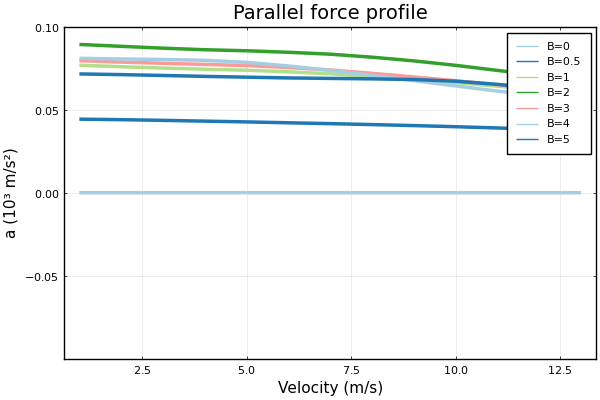

In [35]:
plot(par_pop_vs_B,
        xlabel="Velocity (m/s)",
        ylabel="a (10³ m/s²)",
        title="Parallel force profile",
        framestyle=:box,
        linewidth=2.5,
        fillalpha = 0.2,
        labels=["B=0" "B=0.5" "B=1" "B=2" "B=3" "B=4" "B=5"],
        # legend=nothing,
        # xlim=(0,6),
        ylim=(-0.1,0.1),
        palette=:Paired_5
    )

In [28]:
plot(scan_values.v .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* par_force_vs_B,
        xlabel="Velocity (m/s)",
        ylabel="a (10³ m/s²)",
        title="Parallel force profile",
        framestyle=:box,
        linewidth=2.5,
        ribbons=(1e-3 * ħ * k * Γ / m).* reduce(hcat,par_force_std_vs_B)/2,
        fillalpha = 0.2,
        labels=["B=0" "B=1" "B=5" "B=10" "B=25"],
        # legend=nothing,
        # xlim=(0,6),
        ylim=(-4,1),
        palette=:Paired_5
    )

LoadError: UndefVarError: `par_force_vs_B` not defined

In [ ]:
perp_force_vs_B = Array{Float64}[]
perp_force_std_vs_B = Array{Float64}[]
B_vals = [0,1,5,10,25]
for B in B_vals
    sim_params = (Bx=0, By=B/√2, Bz=B/√2)
    freq_res = 1e-2

    particle.v .= (0, 1., 0)
    p = obe(ρ0, particle, states, lasers_perp, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res, extra_data=extra_data, sim_params=sim_params, update_H_and_∇H=update_H_and_∇H)
    
    t_end = 10p.period
    tspan = (0., t_end)
    
    prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-5, save_on=false)
    
    scan_values_grid = RectiGrids.grid(scan_values)
    ;
    @time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func_perp!, output_func)
    ;
    averaged_forces = Float64[]
    force_std = Float64[]
    for (i,v) ∈ enumerate(scan_values.v)
        idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
        push!(averaged_forces, mean([forces[idx] ⋅ scan_values_grid[idx].dir for idx in idxs]))
        push!(force_std, std([forces[idx] ⋅ scan_values_grid[idx].dir for idx in idxs]))
    end
    push!(perp_force_vs_B,averaged_forces)
    push!(perp_force_std_vs_B, force_std)
end

In [ ]:
plot(scan_values.v .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* perp_force_vs_B,
        xlabel="Velocity (m/s)",
        ylabel="a (10³ m/s²)",
        title="Perpendicular force profile",
        framestyle=:box,
        linewidth=2.5,
        ribbons=(1e-3 * ħ * k * Γ / m).* reduce(hcat,perp_force_std_vs_B)/2,
        fillalpha = 0.2,
        labels=["B=0" "B=1" "B=5" "B=10" "B=25"],
        # legend=nothing,
        # xlim=(0,6),
        ylim=(-4,1),
        palette=:Paired_5
    )

In [ ]:
#Obtained from s1=s2=s3=200 (s=600) and detuning = +12
plot(scan_values.v .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* force_vs_B,
        xlabel="Velocity (m/s)",
        ylabel="a (10³ m/s²)",
        title="Force profile",
        framestyle=:box,
        linewidth=2.5,
        labels=["B=0" "B=1" "B=5" "B=10" "B=15" "B=20" "B=25"],
        # legend=nothing,
        # xlim=(0,6),
        ylim=(-4,1),
        palette=:Oranges_7
    )

In [ ]:
# freq_res = 1e-2

# particle.v .= (0, 1., 0)
# p = obe(ρ0, particle, states, lasers, d, true, true; λ=λ, Γ=Γ, freq_res=freq_res, extra_data=extra_data, sim_params=sim_params, update_H_and_∇H=update_H_and_∇H)

# t_end = 10p.period
# tspan = (0., t_end)

# prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-5, save_on=false)

# scan_values = (
#     v = (0:0.5:6) ./ (Γ / k),
#     ϕ = [π],
#     dir = [(cos(θ),sin(θ),0) for θ ∈ range(0,2π,8)]
# )
# scan_values_grid = RectiGrids.grid(scan_values)
# ;

In [ ]:
# @time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func)
# ;

In [ ]:
# averaged_forces = Float64[]
# for (i,v) ∈ enumerate(scan_values.v)
#     idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v == v]
#     push!(averaged_forces, mean([forces[idx] ⋅ scan_values_grid[idx].dir for idx in idxs]))
# end

In [ ]:
# plot(scan_values.v .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces,
#     xlabel="Velocity (m/s)",
#     ylabel="a (10³ m/s²)",
#     title="Force profile",
#     framestyle=:box,
#     linewidth=2.5,
#     legend=nothing,
#     # xlim=(0,6),
#     ylim=(-4,1)
# )